# Environment setup

## Download code and data


In [ ]:
!pip install imagecodecs tifffile

     |████████████████████████████████| 17.9MB 209kB/s 


In [ ]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 72 (delta 40), reused 43 (delta 18), pack-reused 0
Unpacking objects: 100% (72/72), done.
/content/ml-segmentation-project


In [ ]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  5896k      0  0:00:12  0:00:12 --:--:-- 6583k


## Useful imports and settings

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

import unet
from dataset import CellSegmentationDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [ ]:
BATCH_SIZE = 8
TRAIN_SIZE = 2000

img_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
      transforms.ToTensor(),
      transforms.CenterCrop(512),
])
target_transforms = transforms.Compose([
      transforms.Lambda(lambda img: img.astype(np.float32)),
      transforms.ToTensor(),
      # Limit to 0-1 for foreground-background segmentation
      transforms.Lambda(lambda img: img.clamp(max=1.0)),
      transforms.CenterCrop(512),
])

dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="normal",
                                  transform=img_transforms,
                                  target_transform=target_transforms,
                                )
# Neuroblastoma

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

<Figure size 432x288 with 0 Axes>

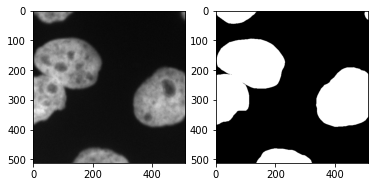

In [ ]:
plt.gray()
f, axes = plt.subplots(1, 2)
image, segm = dataset[1]
axes[0].imshow(image.permute(1, 2, 0).squeeze())
axes[1].imshow(segm.permute(1, 2, 0).squeeze())
plt.show()

# Training

In [ ]:
model = unet.UNet().to(device)

In [ ]:
summary(model, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
TRN_EPOCHS = 10
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
MOMENTUM = 0.99

def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10e3

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            epoch_loss = []
            dice_list = []
            
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(torch.max(outputs), torch.min(outputs))

                    loss = criterion(outputs, labels)
                    dice = dice_loss(outputs, labels).data.cpu().numpy()
                    epoch_loss.append(loss.item())
                    dice_list.append(dice)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                                      
            print("Epoch {} loss: {}".format(phase, np.mean(epoch_loss)))
            print("Epoch {} dice loss: {}".format(phase, np.mean(dice_list)))
                
            # deep copy the model
            if phase == 'val' and np.mean(epoch_loss) < best_loss:
                print("saving best model")
                best_loss = np.mean(epoch_loss)
                best_model_wts = copy.deepcopy(model.state_dict())
        # torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.BCEWithLogitsLoss()

# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [ ]:
model = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 0/9
----------
Epoch train loss: 0.6840944389502207
Epoch train dice loss: 1.1300969123840332
Epoch val loss: 0.6843669414520264
Epoch val dice loss: 1.241355061531067
saving best model
0m 11s
Epoch 1/9
----------
Epoch train loss: 0.6794354418913523
Epoch train dice loss: 1.5118376016616821
Epoch val loss: 0.6661621530850729
Epoch val dice loss: 1.1450754404067993
saving best model
0m 11s
Epoch 2/9
----------
Epoch train loss: 0.6738539238770803
Epoch train dice loss: 1.2175962924957275
Epoch val loss: 0.6503148078918457
Epoch val dice loss: 1.155763030052185
saving best model
0m 11s
Epoch 3/9
----------
Epoch train loss: 0.655855397383372
Epoch train dice loss: 2.5382754802703857
Epoch val loss: 0.6473286549250284
Epoch val dice loss: 1.1732476949691772
saving best model
0m 11s
Epoch 4/9
----------
Epoch train loss: 0.6409736971060435
Epoch train dice loss: 4.756204128265381
Epoch val loss: 0.6290009220441183
Epoch val dice loss: -12.353450775146484
saving best model
0m 12s
Epo